**Online Shoppers Intention**

Import the required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

read the dataset


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


As we are dealing with an unsupervised learning problem, we will drop the 'Revenue' column

In [ ]:
df_copy = df.drop('Revenue', axis=1)
df_copy.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True


In [ ]:
df_copy.shape

(12330, 17)

Our new dataset now has 12330 rows with 17 columns.
Let us check the data type of the variables

In [ ]:
df_copy.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
dtype: object

We have numerical and categorical columns. Let us check if we have any missing values in the data

In [ ]:
df_copy.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
dtype: int64

We dont have any missing or null values.
Let us now check the relationships among the various features

In [ ]:
#plot pairplot

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


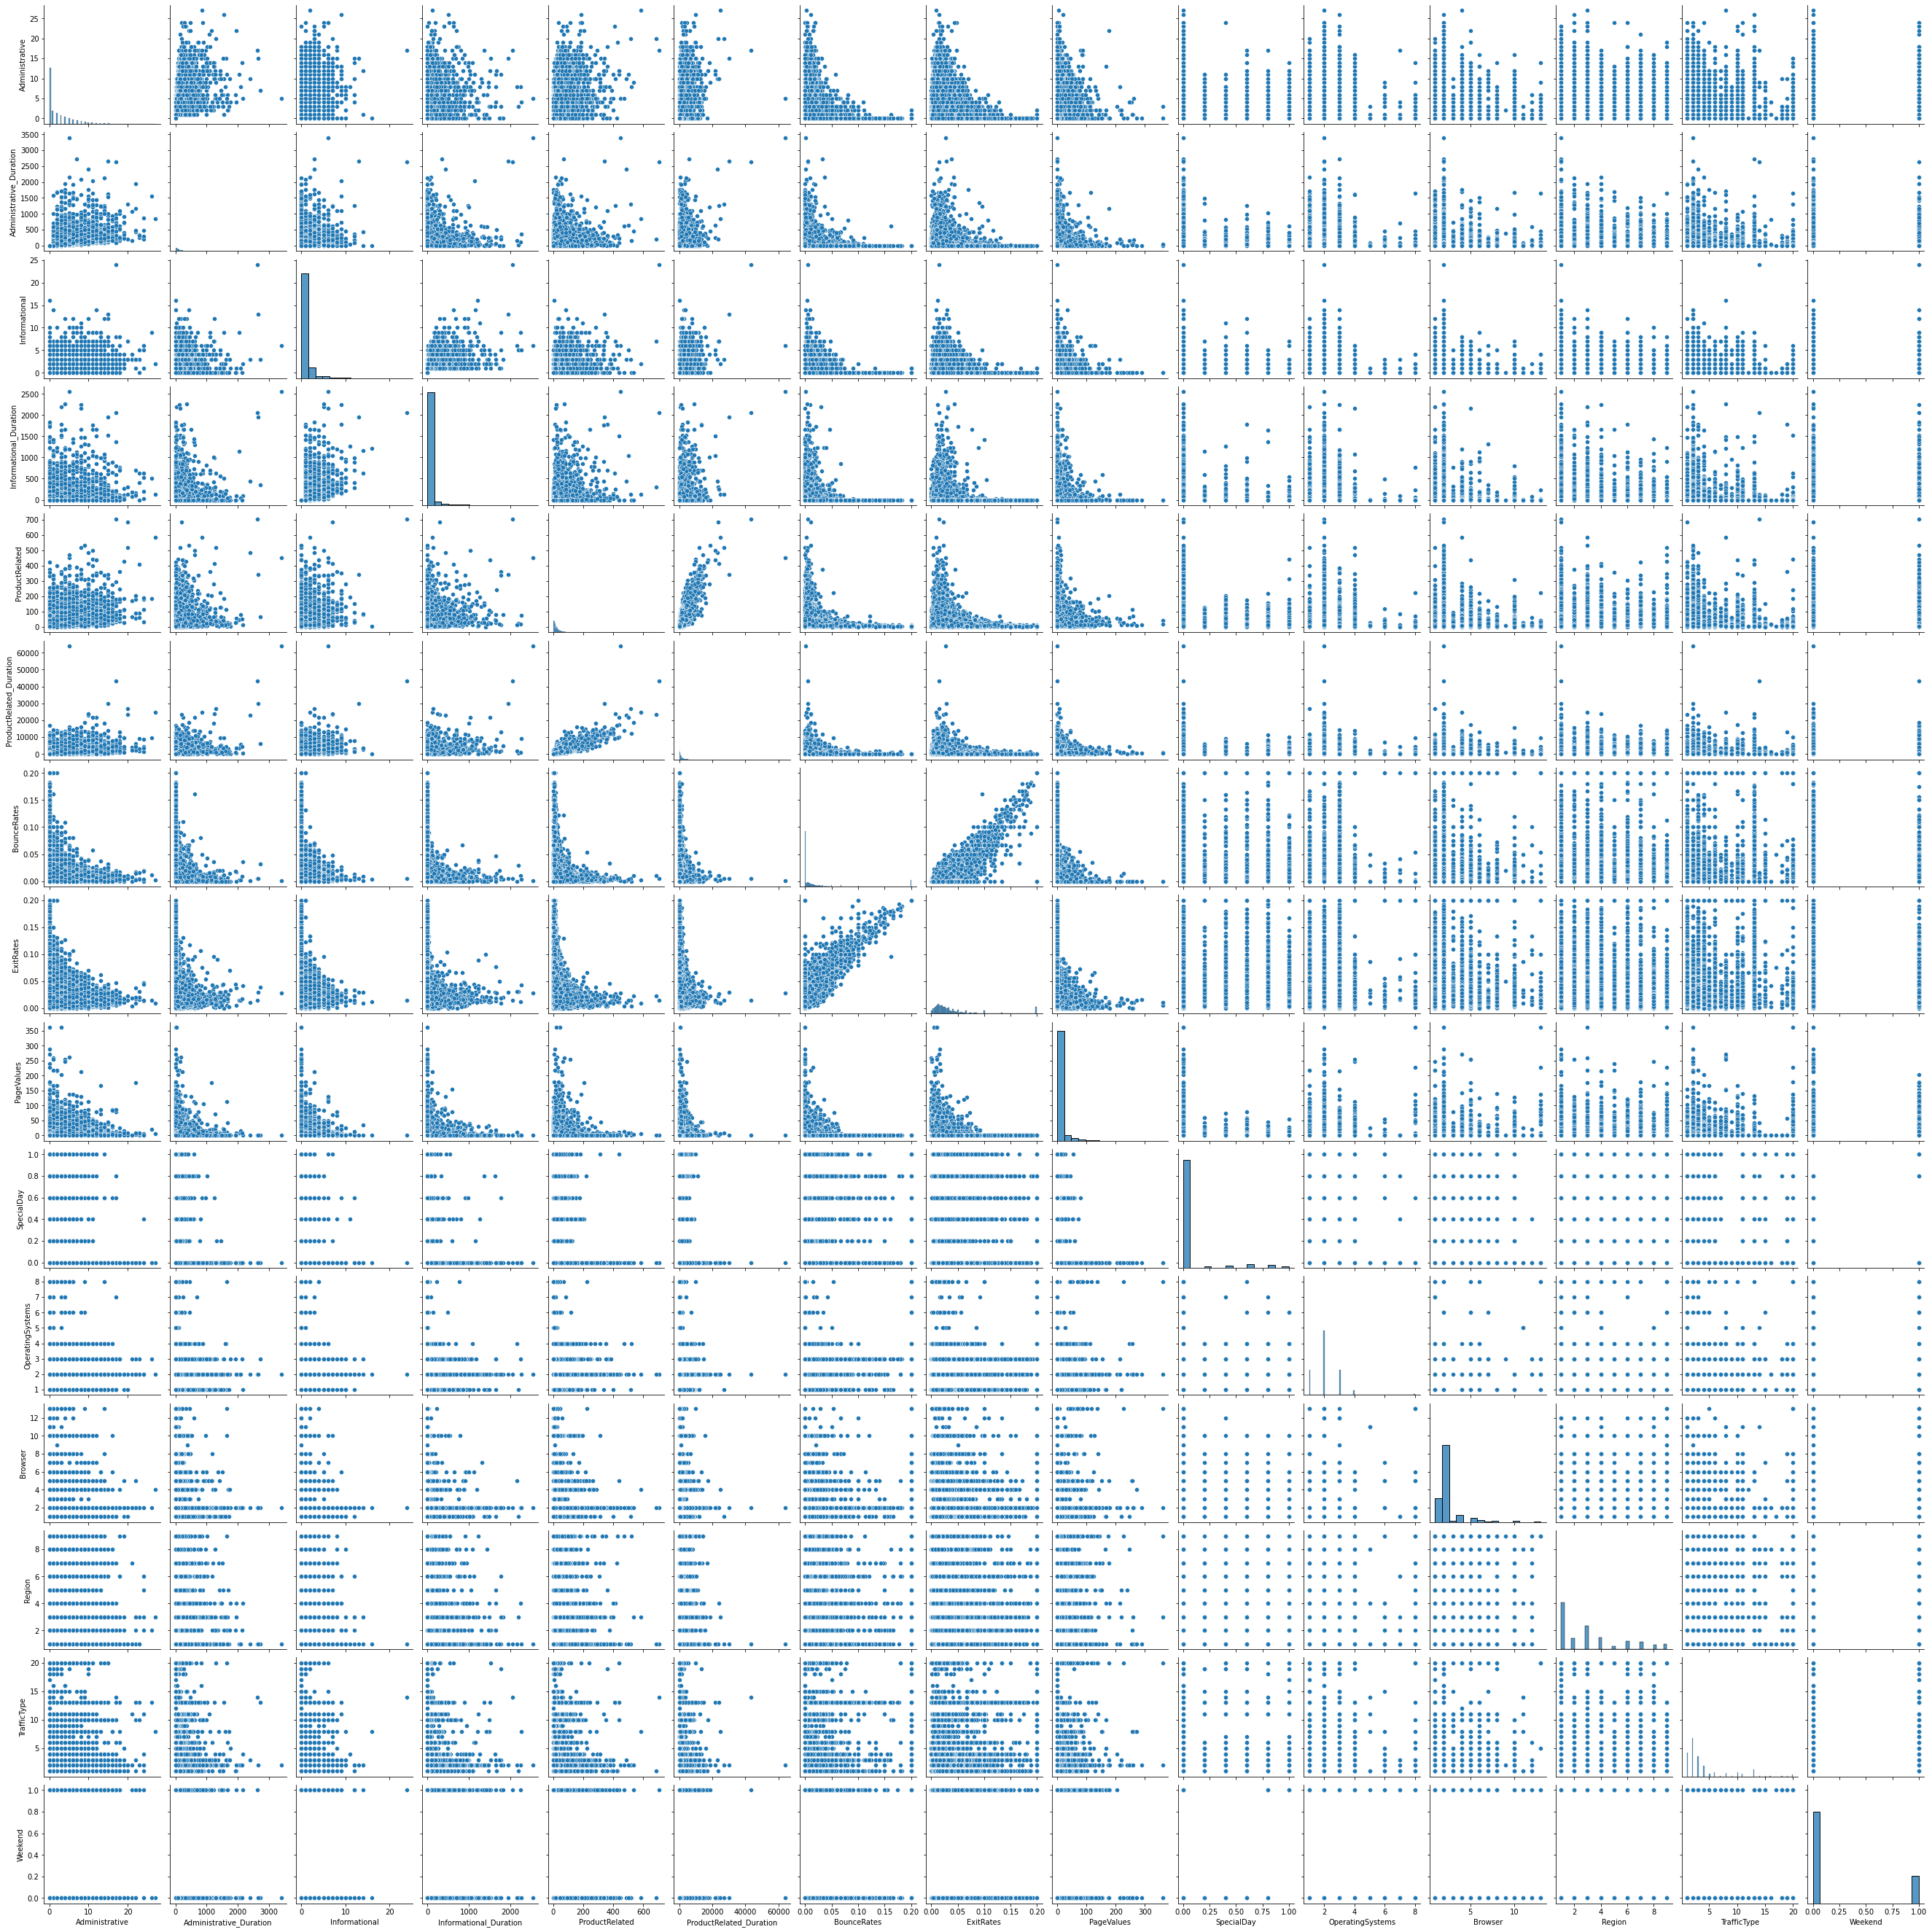

In [ ]:
sns.pairplot(data=df_copy)

Based on the pair plot, we can see some linear relationships between attributes such as product related, product related duration and bounce rates and exit rates.

Let us check the correlation between the features.

Our goal here is to remove all those features which are not much correlated with other features so as help improve the clustering process.

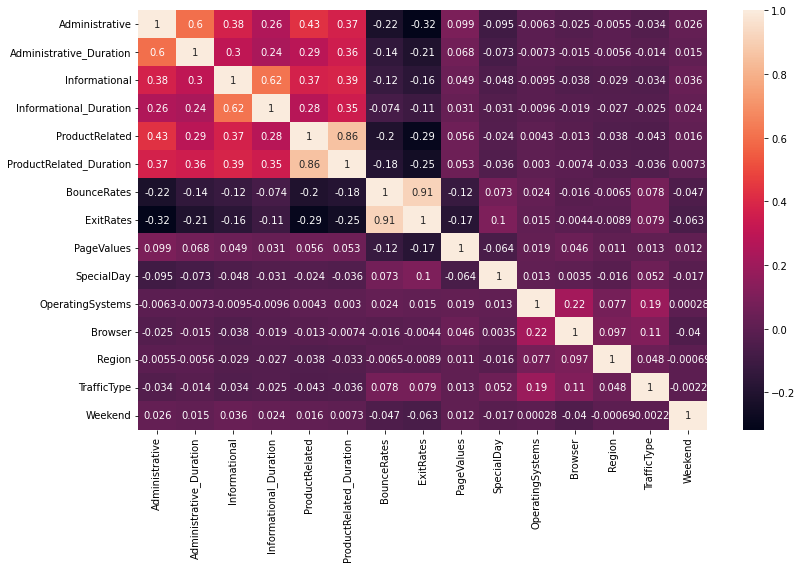

In [ ]:
#plot the correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_copy.corr(), annot=True)
plt.tight_layout()
plt.show()

For any website, the company would want the customers to spend as much longer duration on their product pages.
Also, the company would want to have significant less bounce rates

As per google analytics, the Bounce rate is the percentage of visitors who left the website without triggering any request to other pages on the website.

Therefore, we will consider the bounce rate and the exit rates as our two for further clustering of the customers.

In [ ]:
#select only the bounce rate and product related duration columns
new_df = df_copy[['ProductRelated_Duration', 'BounceRates']]
new_df.shape

(12330, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


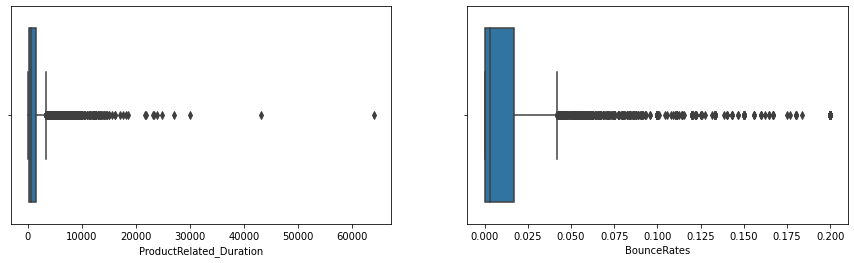

In [ ]:
#Check presence of outliers in the columns
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 4))

for variable, subplot in zip(new_df.columns, ax.flatten()):
    
    # use boxplot() to plot the graph
    # pass the axes for the plot to the parameter, 'ax'
    sns.boxplot(new_df[variable], ax = subplot)

#plot the graph
plt.show()


We will remove the outliers for the clustering analysis.

In [ ]:
new_df[new_df['ProductRelated_Duration'] > 20000]

,ProductRelated_Duration,BounceRates
5152,43171.23338,0.004851
5916,21857.04648,0.003589
6165,23050.10414,0.000324
6684,23342.08205,0.009853
7662,23888.81000,0.009900
8071,63973.52223,0.000764
8308,24844.15620,0.002099
8784,27009.85943,0.004385
8972,21672.24425,0.003965
9238,29970.46597,0.005316


We'll remove these outliers for the product related duration column

In [ ]:
new_df = new_df[new_df['ProductRelated_Duration'] < 20000]

In [ ]:
new_df['ProductRelated_Duration'].max()

18504.12621

In [ ]:
#Removing outliers for bounce rate column
new_df[new_df['BounceRates'] > 0.100]

,ProductRelated_Duration,BounceRates
0,0.0,0.2
2,0.0,0.2
6,0.0,0.2
7,0.0,0.2
16,0.0,0.2
...,...,...
12197,0.0,0.2
12200,0.0,0.2
12220,0.0,0.2
12301,0.0,0.2


In [ ]:
new_df = new_df[new_df['BounceRates'] < 0.100]

In [ ]:
new_df['BounceRates'].max()

0.095833333

In [ ]:
new_df.shape

(11406, 2)

We have removed the significant outlier points in both columns.
Let us scale the data

In [ ]:
#perform scaling using standard scaler
scaler = StandardScaler()

df_scaled = pd.DataFrame(data=scaler.fit_transform(new_df), columns=new_df.columns)
df_scaled.head()

,ProductRelated_Duration,BounceRates
0,-0.696188,-0.596512
1,-0.731834,2.551883
2,-0.368697,0.662846
3,-0.643757,0.397718
4,-0.711880,-0.596512


**Apply K means clustering**

Find optimal value of K using elbow method

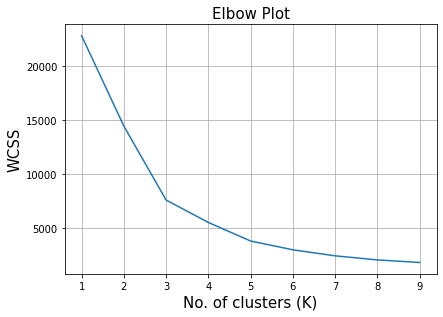

In [ ]:
#within cluster sum of sqaures
wcss = []

for i in range(1, 10):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 10)
    #fit the data
    km.fit(df_scaled)
    labels = km.labels_
    wcss.append(km.inertia_)

plt.plot(range(1, 10), wcss)
plt.grid()
plt.tight_layout()
plt.title('Elbow Plot', fontsize = 15)
plt.xlabel('No. of clusters (K)', fontsize = 15)
plt.ylabel('WCSS', fontsize = 15)
plt.show()

From the above graph, it can be seen that the elbow is formed at K=3. 

Therfore, we can fit the k means model with n_clusters=3

But before let us check the optimal value of K by the silhouette score

In [ ]:
# create a list for different values of K
n_clusters = [2, 3, 4, 5, 6]

# 'silhouette_score' function computes the silhouette score for each K
for K in n_clusters:
    cluster = KMeans(n_clusters= K, random_state= 10)
    #fit and predict on the scaled data
    predict = cluster.fit_predict(df_scaled)
    #print the silhouette scores
    score = silhouette_score(df_scaled, predict, random_state= 10)
    print ("For {} clusters the silhouette score is {})".format(K, score))

For 2 clusters the silhouette score is 0.5812186384803603)
For 3 clusters the silhouette score is 0.6234163446415844)
For 4 clusters the silhouette score is 0.5358637596888491)
For 5 clusters the silhouette score is 0.5553962910846593)
For 6 clusters the silhouette score is 0.514665409712166)


We can observe that the silhouette score is highest for K=3. Therefore, we will choose K=3 as the optimal number of clusters.

In [ ]:
#Build the clusters using KMeans clustering


In [ ]:
#build the clusters with k=3
new_clusters = KMeans(n_clusters = 3, init = 'k-means++', random_state = 10)

#fit the model
predictions = new_clusters.fit_predict(df_scaled)

new_df['Cluster'] = new_clusters.labels_

In [ ]:
df_copy['Cluster'] = new_clusters.labels_

ValueError: ignored

In [ ]:
#check the head of new_df
new_df.head()

,ProductRelated_Duration,BounceRates,Cluster
1,64.000000,0.000000,0
3,2.666667,0.050000,1
4,627.500000,0.020000,0
5,154.216667,0.015789,0
8,37.000000,0.000000,0


In [ ]:
#check the size of the clusters
new_df['Cluster'].value_counts()

0    8918
1    1449
2    1039
Name: Cluster, dtype: int64

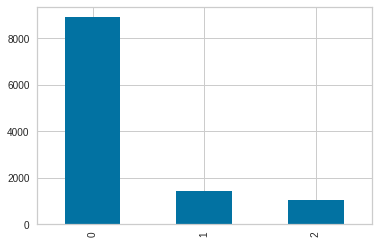

In [ ]:
#plot the clusters
new_df['Cluster'].value_counts().plot(kind='bar')

In [ ]:
#We can see that the firt cluster is larger than compared to the other clusters.

Let us visualize the clusters by considering the two independent variables ProductRelated_Duration and Bounce rates

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


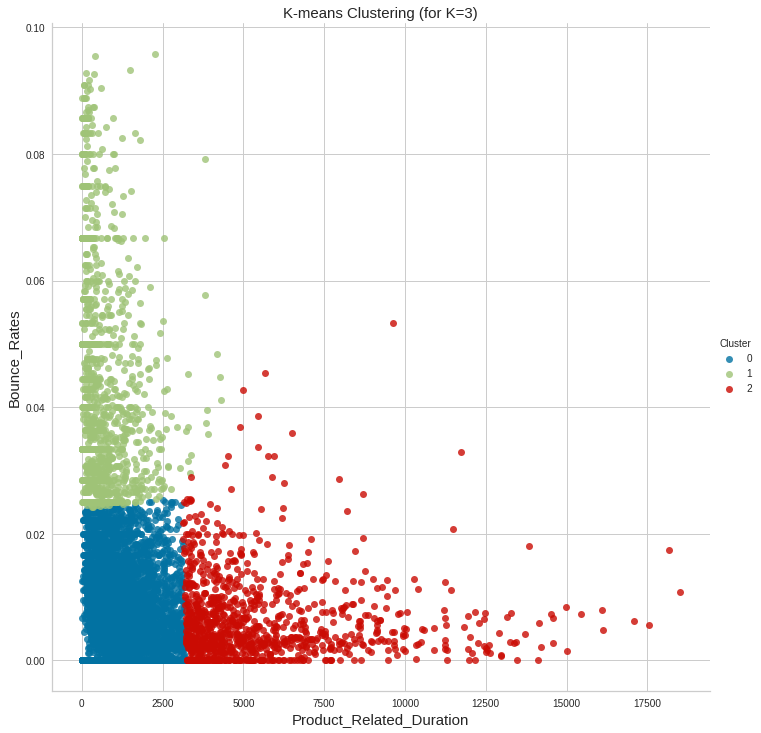

In [ ]:
#plot lmplot to visualize the clusters
sns.lmplot(x = 'ProductRelated_Duration', y = 'BounceRates', data = new_df, hue = 'Cluster', 
                fit_reg = False, size = 10)

# set the axes and plot labels
# set the font size using 'fontsize'
plt.title('K-means Clustering (for K=3)', fontsize = 15)
plt.xlabel('Product_Related_Duration', fontsize = 15)
plt.ylabel('Bounce_Rates', fontsize = 15)

# display the plot
plt.show()

Looking at the graph above, we can infer the following:

1. For cluster 0, there are a large number of visitors who spend less time on product related pages and have low bounce rates.
2. For cluster 1, there are visitors who have a high bounce rates but spend less time on the product related pages.
3. For cluster 2, the visitors spend more time on the product pages and have low bounce rates.

Visitors in cluster 2 would add more revenue to the company based on their browsing behaviour as more time they spend on the product related pages, the more they are likely to buy the company's offerings.

Let us analyze the individual clusters

**Cluster 1**

In [ ]:
new_df[new_df['Cluster'] == 0].describe()

,ProductRelated_Duration,BounceRates,Cluster
count,8918.000000,8918.000000,8918.0
mean,876.721666,0.004132,0.0
std,775.077195,0.006423,0.0
min,0.000000,0.000000,0.0
25%,255.000000,0.000000,0.0
50%,638.958333,0.000000,0.0
75%,1306.082005,0.007143,0.0
max,3230.546573,0.025424,0.0


**Cluster 2**

In [ ]:
new_df[new_df['Cluster'] == 1].describe()

,ProductRelated_Duration,BounceRates,Cluster
count,1449.000000,1449.000000,1449.0
mean,561.375300,0.044499,1.0
std,659.943882,0.017043,0.0
min,0.000000,0.024242,1.0
25%,117.500000,0.030000,1.0
50%,297.500000,0.040000,1.0
75%,780.000000,0.054545,1.0
max,4293.400000,0.095833,1.0


**Cluster 3**

In [ ]:
new_df[new_df['Cluster'] == 2].describe()

,ProductRelated_Duration,BounceRates,Cluster
count,1039.000000,1039.000000,1039.0
mean,5544.951375,0.006473,2.0
std,2538.271566,0.006718,0.0
min,3141.258333,0.000000,2.0
25%,3763.307128,0.001961,2.0
50%,4656.331746,0.004420,2.0
75%,6392.398544,0.008889,2.0
max,18504.126210,0.053355,2.0


Analyze the clusters with respect to all features in the dataset

In [ ]:
df_cluster = df_copy.iloc[:11406,:]
df_cluster.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True


In [ ]:
#create the column with Clusters
df_cluster['Cluster'] = new_clusters.labels_
df_cluster.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Cluster
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,0


In [ ]:
df_cluster['Cluster'].value_counts()

0    8918
1    1449
2    1039
Name: Cluster, dtype: int64

**Cluster 1**

In [ ]:
df_cluster[df_cluster['Cluster'] == 0].describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Cluster
count,8918.000000,8918.000000,8918.000000,8918.000000,8918.000000,8918.000000,8918.000000,8918.000000,8918.000000,8918.00000,8918.000000,8918.000000,8918.000000,8918.000000,8918.0
mean,2.296479,79.270015,0.500785,35.252455,31.292106,1179.078988,0.022286,0.043497,5.866191,0.06488,2.105517,2.348172,3.156313,4.024893,0.0
std,3.324108,175.350072,1.282533,142.381158,45.035951,1974.829593,0.048646,0.048833,18.691254,0.20397,0.855863,1.665067,2.397526,3.955206,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,7.000000,180.541667,0.000000,0.014171,0.000000,0.00000,2.000000,2.000000,1.000000,2.000000,0.0
50%,1.000000,7.000000,0.000000,0.000000,17.000000,589.070238,0.002899,0.025758,0.000000,0.00000,2.000000,2.000000,3.000000,2.000000,0.0
75%,4.000000,91.000000,0.000000,0.000000,37.000000,1436.630357,0.017101,0.050000,0.000000,0.00000,2.000000,2.000000,4.000000,4.000000,0.0
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.00000,8.000000,13.000000,9.000000,20.000000,0.0


**Cluster 2**

In [ ]:
df_cluster[df_cluster['Cluster'] == 1].describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Cluster
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.0
mean,2.287095,83.636232,0.448585,28.786130,27.420290,1021.929676,0.023219,0.042964,5.518055,0.093444,2.148378,2.315390,3.200138,4.119393,1.0
std,3.167577,176.136902,1.146222,129.613684,33.446162,1391.927799,0.049459,0.049474,16.721114,0.238358,0.954453,1.608177,2.419128,4.054902,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,7.000000,188.400000,0.000000,0.014219,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,1.0
50%,1.000000,11.000000,0.000000,0.000000,17.000000,562.666667,0.003125,0.025000,0.000000,0.000000,2.000000,2.000000,3.000000,3.000000,1.0
75%,4.000000,98.500000,0.000000,0.000000,35.000000,1330.375000,0.019048,0.049225,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000,1.0
max,21.000000,2720.500000,11.000000,2252.033333,330.000000,13717.402050,0.200000,0.200000,254.607158,1.000000,8.000000,13.000000,9.000000,20.000000,1.0


**Cluster 3**

In [ ]:
df_cluster[df_cluster['Cluster'] == 2].describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Cluster
count,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1039.0
mean,2.435034,87.270411,0.543792,33.720319,34.068335,1266.004948,0.022064,0.041815,6.159325,0.041771,2.146295,2.390760,3.128970,4.078922,2.0
std,3.415279,176.301949,1.214776,137.839847,42.753744,1713.108590,0.048164,0.047720,18.575903,0.167456,0.966572,1.847602,2.403578,4.062082,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.0
25%,0.000000,0.000000,0.000000,0.000000,8.000000,184.354167,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,2.0
50%,1.000000,11.000000,0.000000,0.000000,20.000000,619.400000,0.004167,0.024713,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.0
75%,4.000000,100.000000,0.000000,0.000000,42.000000,1701.520834,0.016912,0.046667,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000,2.0
max,24.000000,1715.000000,9.000000,2195.300000,357.000000,15454.438570,0.200000,0.200000,218.395192,1.000000,8.000000,13.000000,9.000000,20.000000,2.0


# Applying PCA on the dataset

In [ ]:
#check head of df_copy
df_copy.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True


For applying PCA on the data, we need to scale the data

In [ ]:
df_copy.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
dtype: object

In [ ]:
#convert Weekend to object data type
df_copy['Weekend'] = df_copy['Weekend'].astype('object')

In [ ]:
df_copy['Weekend'].dtypes

dtype('O')

In [ ]:
#convert month to int type
df_copy['Month'].value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

In [ ]:
df_copy['Month'] = df_copy['Month'].replace({'Feb':2, 'Mar':3, 'May':5, 'June':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12})
df_copy['Month'].dtypes

dtype('int64')

In [ ]:
df_copy['Month'].value_counts()

5     3364
11    2998
3     1907
12    1727
10     549
9      448
8      433
7      432
6      288
2      184
Name: Month, dtype: int64

In [ ]:
#encode the categorical variables
df_encoded = pd.get_dummies(df_copy, drop_first=True)
df_encoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,0,1,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,0,1,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,0,1,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,0,1,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,0,1,1


Perform scaling to apply PCA

In [ ]:
df_scaled_pca = pd.DataFrame(data=scaler.fit_transform(df_encoded), columns=df_encoded.columns)
df_scaled_pca.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,-1.665924,-1.233426,-0.790293,-0.894178,-0.762629,-0.083316,0.410621,-0.550552
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,-1.665924,-0.136078,-0.207952,-0.894178,-0.514182,-0.083316,0.410621,-0.550552
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,-1.665924,2.058618,-0.790293,2.437081,-0.265735,-0.083316,0.410621,-0.550552
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,-1.665924,0.961270,-0.207952,-0.477771,-0.017289,-0.083316,0.410621,-0.550552
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,-1.665924,0.961270,0.374389,-0.894178,-0.017289,-0.083316,0.410621,1.816360


We find to find the number of components that explain atleast 80% of variation in the data.
We will do this by using the percentage of explained variation method

In [ ]:
#instantiate the pca function
pca = PCA()

#fit the scaled data
pca.fit(df_scaled_pca)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
#get the number of components that explain 80% variation in the data
cumsum = np.cumsum(pca.explained_variance_ratio_)
comp = np.argmax(cumsum >= 0.8) + 1
print("The number of components required is:", comp)

The number of components required is: 11


Fit the model with 11 principal components

In [ ]:
pca = PCA(n_components=11, random_state=10)
pca_comp = pca.fit_transform(df_scaled_pca)

In [ ]:
# create a dataframe of principal components
# pass the required column names to the parameter 'columns'
df_pca = pd.DataFrame(data = pca_comp, columns = ['PC' + str(i) for i in range(1,12)])

df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-3.331249,-3.419328,1.675702,-1.255974,0.630218,1.020226,0.150463,0.557503,0.485808,-1.044259,0.466707
1,-1.543760,-0.909297,-0.486938,0.611136,0.285377,0.277734,0.645768,0.477748,-0.510597,-0.654198,-0.541247
2,-3.480948,-1.577366,3.294647,-0.529962,0.650372,1.047713,-0.157758,-1.890826,1.198604,-0.088218,-0.344292
3,-2.161115,-0.931213,0.902546,0.416727,0.325430,0.346744,0.268533,0.374803,-0.335394,-0.479514,-0.694325
4,-1.106958,-0.063233,-0.171105,0.953072,0.499264,-1.425762,-0.982561,0.291735,-0.309495,-1.310489,-1.029523


In [ ]:
pd.DataFrame(pca.components_, columns=df_scaled_pca.columns)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True
0,0.377694,0.323524,0.342653,0.290781,0.408885,0.409729,-0.277014,-0.323324,0.093288,-0.081888,0.114282,-0.016610,-0.021344,-0.020867,-0.051325,-0.030749,0.002385,0.033946
1,-0.000437,-0.022036,-0.149834,-0.155030,-0.106279,-0.120175,-0.307365,-0.308920,0.203399,-0.142524,0.191609,0.329425,0.344068,0.196750,0.205386,0.437725,-0.373118,0.019260
2,0.051746,0.094160,0.203985,0.221416,0.143908,0.176771,0.457424,0.434052,-0.078559,0.070608,0.056569,0.344717,0.269913,0.101630,0.292955,0.352979,0.123767,-0.078249
3,-0.067558,-0.084468,-0.054108,-0.051259,0.109600,0.094395,-0.261130,-0.215598,-0.112495,0.625976,-0.543813,0.183652,0.201037,0.023187,0.088914,0.029587,0.239818,-0.077096
4,0.178904,0.250146,0.341045,0.378408,-0.412221,-0.366823,0.039987,0.031753,0.135550,0.154694,-0.367719,-0.051477,-0.056556,0.059079,-0.014470,0.040824,-0.322287,0.214984
5,0.373812,0.465470,-0.226314,-0.304710,-0.052847,-0.052895,0.109709,0.080630,0.107033,0.008108,-0.147996,-0.111351,0.040434,0.131759,-0.090287,-0.013637,-0.046131,-0.632553
6,-0.281360,-0.336834,0.281521,0.382853,-0.072758,-0.042991,-0.101976,-0.061660,0.073157,-0.122427,0.006739,-0.074034,0.186014,0.026403,-0.306813,0.063542,0.000894,-0.633141
7,-0.016384,-0.017108,-0.013451,-0.010024,0.006217,0.002168,0.037083,0.015944,0.434055,0.114118,0.016670,0.060789,-0.040909,-0.832805,0.253254,0.023457,-0.098061,-0.150147
8,-0.099220,-0.140313,-0.045290,-0.046431,0.151647,0.145258,0.150134,0.102120,0.810103,0.149592,-0.050598,-0.145644,0.020849,0.374448,-0.110933,-0.065663,0.064377,0.159278
9,-0.057047,-0.079635,0.087834,0.107355,-0.056228,-0.055095,-0.100516,-0.089071,0.019810,0.121779,0.170828,-0.118094,-0.434594,0.296869,0.716171,-0.147796,0.025318,-0.276025


Here we can summarize the contribution of individual features for each cluster.

In [ ]:
#create a biplot 

In [ ]:
df_scaled_pca.shape

(12330, 18)

In [ ]:
df_pca.shape

(12330, 11)